# Определение перспективного тарифа для телеком-компании

### Описание проекта

Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

### Описание тарифов

**Тариф «Смарт»**
* Ежемесячная плата: 550 рублей
* Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
* Стоимость услуг сверх тарифного пакета:
* минута разговора: 3 рубля
* сообщение: 3 рубля
* 1 Гб интернет-трафика: 200 рублей

**Тариф «Ультра»**
* Ежемесячная плата: 1950 рублей
* Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
* Стоимость услуг сверх тарифного пакета:
* минута разговора: 1 рубль
* сообщение: 1 рубль
* 1 Гб интернет-трафика: 150 рублей

### Описание данных

**Таблица users (информация о пользователях)** :
* user_id — уникальный идентификатор пользователя
* first_name — имя пользователя
* last_name — фамилия пользователя
* age — возраст пользователя (годы)
* reg_date — дата подключения тарифа (день, месяц, год)
* churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* city — город проживания пользователя
* tariff — название тарифного плана

**Таблица calls (информация о звонках)**:
* id — уникальный номер звонка
* call_date — дата звонка
* duration — длительность звонка в минутах
* user_id — идентификатор пользователя, сделавшего звонок

**Таблица messages (информация о сообщениях)**:
* id — уникальный номер сообщения
* message_date — дата сообщения
* user_id — идентификатор пользователя, отправившего сообщение

**Таблица internet (информация об интернет-сессиях)**:
* id — уникальный номер сессии
* mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
* session_date — дата интернет-сессии
* user_id — идентификатор пользователя

**Таблица tariffs (информация о тарифах)**:
* tariff_name — название тарифа
* rub_monthly_fee — ежемесячная абонентская плата в рублях
* minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
* messages_included — количество сообщений в месяц, включённых в абонентскую плату
* mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* rub_per_message — стоимость отправки сообщения сверх тарифного пакета
* rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns
import warnings

In [2]:
try:
    calls = pd.read_csv('/Users/arinaleonteva/Downloads/calls.csv')
    internet = pd.read_csv('/Users/arinaleonteva/Downloads/internet.csv')
    messages = pd.read_csv('/Users/arinaleonteva/Downloads/messages.csv')
    tariffs = pd.read_csv('/Users/arinaleonteva/Downloads/tariffs.csv')
    users = pd.read_csv('/Users/arinaleonteva/Downloads/users.csv')
except:
    calls = pd.read_csv('/datasets/calls.csv')
    internet = pd.read_csv('/datasets/internet.csv')
    messages = pd.read_csv('/datasets/messages.csv')
    tariffs = pd.read_csv('/datasets/tariffs.csv')
    users = pd.read_csv('/datasets/users.csv')



In [3]:
calls.info()
internet.info()
messages.info()
tariffs.info()
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 co

### Изучение фреймов

#### calls

In [4]:
print(calls.isna().mean())
print(calls.head())


id           0.0
call_date    0.0
duration     0.0
user_id      0.0
dtype: float64
       id   call_date  duration  user_id
0  1000_0  2018-07-25      0.00     1000
1  1000_1  2018-08-17      0.00     1000
2  1000_2  2018-06-11      2.85     1000
3  1000_3  2018-09-21     13.80     1000
4  1000_4  2018-12-15      5.18     1000


Нет пропусков, но в двух столбцах следует заменить типы данных

       id  call_date  duration  user_id  month
0  1000_0 2018-07-25         0     1000      7
1  1000_1 2018-08-17         0     1000      8
2  1000_2 2018-06-11         3     1000      6
3  1000_3 2018-09-21        14     1000      9
4  1000_4 2018-12-15         6     1000     12
5  1000_5 2018-11-02         0     1000     11
6  1000_6 2018-10-18         0     1000     10
7  1000_7 2018-08-22        19     1000      8
8  1000_8 2018-09-15        19     1000      9
9  1000_9 2018-08-15         0     1000      8
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  int64         
 3   user_id    202607 non-null  int64         
 4   month      202607 non-null  int64         
dtypes: datetime64[ns](1), int64(3), 

,duration,user_id,month
count,202607.000000,202607.000000,202607.000000
mean,7.158198,1253.940619,8.574067
std,5.959173,144.722751,2.787093
min,0.000000,1000.000000,1.000000
25%,2.000000,1126.000000,7.000000
50%,6.000000,1260.000000,9.000000
75%,11.000000,1379.000000,11.000000
max,38.000000,1499.000000,12.000000


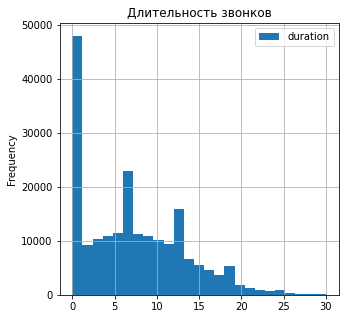

In [5]:
# замена типа в столбце с датой
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
#добавление столбца с месяцем
calls['month'] = calls['call_date'].dt.month

# нужно округлить длительность звонков 
def ceil_value(value):
    return math.ceil(value)
calls['duration'] = calls['duration'].apply(ceil_value)  
np.int64(calls['duration'])
print(calls.head(10))
calls.info()
calls.plot(y = 'duration', kind = 'hist', bins = 25, grid=True, figsize = (5,5), range = (0,30)).set_title('Длительность звонков')
calls.describe()


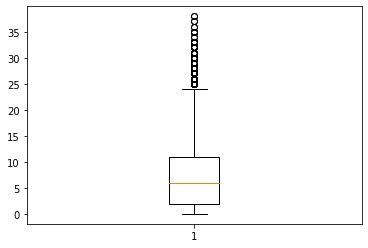

In [6]:
plt.boxplot(x=calls['duration'])
plt.show()

C пропущенными звонками, то есть звонками с нулевой длительностью все понятно, нужно разобраться в пиках на гистограмме в значениях 6 минут, 13 минут и 18 минут

#### internet

In [7]:
print(internet.isna().mean())
print(internet.head())
# удаление повторяющегося столбца
#internet = internet.drop('Unnamed: 0', axis = 1)


Unnamed: 0      0.0
id              0.0
mb_used         0.0
session_date    0.0
user_id         0.0
dtype: float64
   Unnamed: 0      id  mb_used session_date  user_id
0           0  1000_0   112.95   2018-11-25     1000
1           1  1000_1  1052.81   2018-09-07     1000
2           2  1000_2  1197.26   2018-06-25     1000
3           3  1000_3   550.27   2018-08-22     1000
4           4  1000_4   302.56   2018-09-24     1000


Аналогично нужно поменять тип данных в столбце с датой и округлить значения в мегабайтах

In [8]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
# столбец с месяцем
internet['month'] = internet['session_date'].dt.month

# нужно округлить длительность звонков 
def ceil_value(value):
    return math.ceil(value)
internet['mb_used'] = internet['mb_used'].apply(ceil_value)  
np.int64(internet['mb_used'])


array([ 113, 1053, 1198, ...,    0, 1247,  545])

####  messages

In [9]:
print(messages.isna().mean())
print(messages.head())

id              0.0
message_date    0.0
user_id         0.0
dtype: float64
       id message_date  user_id
0  1000_0   2018-06-27     1000
1  1000_1   2018-10-08     1000
2  1000_2   2018-08-04     1000
3  1000_3   2018-06-16     1000
4  1000_4   2018-12-05     1000


In [10]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
# столбец с месяцем
messages['month'] = messages['message_date'].dt.month


#### tariffs

In [11]:
print(tariffs.isna().mean())
display(tariffs.head())

messages_included        0.0
mb_per_month_included    0.0
minutes_included         0.0
rub_monthly_fee          0.0
rub_per_gb               0.0
rub_per_message          0.0
rub_per_minute           0.0
tariff_name              0.0
dtype: float64


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Все столбцы в формате int

#### users

In [12]:
# замена имени столбца для дальнейшего объединения
users.rename(columns=lambda x: x.replace('tariff', 'tariff_name'), inplace=True)
print(users.isna().mean())
display(users.head())


user_id        0.000
age            0.000
churn_date     0.924
city           0.000
first_name     0.000
last_name      0.000
reg_date       0.000
tariff_name    0.000
dtype: float64


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff_name
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [13]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format = '%Y-%m-%d')


Пропуски в столбце churn_date обозначают, что тариф еще действует у конкретного пользователя на момент выгрузки данных

In [14]:
print(calls.duplicated().sum())
print(messages.duplicated().sum())
print(internet.duplicated().sum())
print(users.duplicated().sum())
print(tariffs.duplicated().sum())


0
0
0
0
0


#### Количество сделанных звонков и израсходованных минут разговора по месяцам

In [15]:
calls_duration_pivot = calls.pivot_table(index=['user_id'], columns='month', values='duration', aggfunc=['count','sum'])
calls_duration_pivot.fillna('')

count                                                          ...  \
month      1     2     3     4     5     6     7     8      9      10  ...   
user_id                                                                ...   
1000                             22.0  43.0  47.0  52.0   58.0   57.0  ...   
1001                                                                   ...   
1002                                   15.0  26.0  42.0   36.0   33.0  ...   
1003                                               55.0  134.0  108.0  ...   
1004                              9.0  31.0  22.0  19.0   26.0   29.0  ...   
...       ...   ...   ...   ...   ...   ...   ...   ...    ...    ...  ...   
1495                                               17.0  112.0  152.0  ...   
1496      7.0  77.0  79.0  67.0  63.0  74.0  73.0  88.0   68.0   72.0  ...   
1497                                                             66.0  ...   
1498                                         23.0  57.0   59.0   41.0  ...   
1499                                                       9.0   68.0  ...   

           sum                                                           \
month       3      4      5      6      7      8      9       10     11   
user_id                                                                   
1000                   159.0  172.0  340.0  408.0  466.0   350.0  338.0   
1001                                                              430.0   
1002                          117.0  214.0  289.0  206.0   212.0  243.0   
1003                                        380.0  961.0   855.0  824.0   
1004                    35.0  171.0  135.0  137.0  117.0   145.0  117.0   
...        ...    ...    ...    ...    ...    ...    ...     ...    ...   
1495                                         92.0  813.0  1030.0  954.0   
1496     557.0  521.0  484.0  555.0  582.0  527.0  486.0   450.0  662.0   
1497                                                       490.0  371.0   
1498                                 175.0  400.0  471.0   247.0          
1499                                                70.0   449.0  612.0   

                 
month        12  
user_id          
1000      333.0  
1001      414.0  
1002      236.0  
1003      802.0  
1004      130.0  
...         ...  
1495     1031.0  
1496      518.0  
1497      545.0  
1498             
1499      492.0  

[492 rows x 24 columns]

Создала сводную таблицу из длительности звонков каждого пользователя по месяцам, для наглядости пропуски заполнила пробелом.
<dev> Данные во фреймах о 500 пользователях, 8 из них не пользовались звонками за 2018 год


#### Количество отправленных сообщений по месяцам

In [16]:
messages_pivot = messages.pivot_table(index=['user_id'], columns='month', values='message_date', aggfunc='count')
messages_pivot.fillna('')

month,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1000,,,,,22.0,60.0,75.0,81.0,57.0,73.0,58.0,70.0
1002,,,,,,4.0,11.0,13.0,4.0,10.0,16.0,12.0
1003,,,,,,,,37.0,91.0,83.0,94.0,75.0
1004,,,,,95.0,134.0,181.0,151.0,146.0,165.0,158.0,162.0
1005,7.0,38.0,56.0,41.0,42.0,47.0,56.0,64.0,52.0,44.0,51.0,54.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,,,,,,,,13.0,82.0,82.0,79.0,84.0
1496,9.0,45.0,46.0,49.0,40.0,35.0,42.0,41.0,29.0,35.0,46.0,51.0
1497,,,,,,,,,,20.0,14.0,17.0


74 пользователя не отправили ни одного сообщения за 2018 год

#### Объем израсходованного интернет-трафика по месяцам

In [17]:
internet_pivot = internet.pivot_table(index=['user_id'], columns='month', values='mb_used', aggfunc='sum')
internet_pivot.fillna('')

month,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1000,,,,,2256.0,23257.0,14016.0,14070.0,14581.0,14717.0,14768.0,9827.0
1001,,,,,,,,,,,18452.0,14053.0
1002,,,,,,10871.0,17601.0,20347.0,16712.0,13905.0,18610.0,18137.0
1003,,,,,,,,8571.0,12479.0,14779.0,11368.0,10132.0
1004,,,,,13415.0,17619.0,22243.0,28607.0,15125.0,18494.0,15631.0,18038.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,,,,,,,,2616.0,33105.0,29393.0,38972.0,23450.0
1496,3766.0,28523.0,24990.0,21098.0,23740.0,20163.0,24395.0,23560.0,26970.0,28215.0,25092.0,20757.0
1497,,,,,,,,,,11512.0,14174.0,19940.0


Аналогично с таблицами выше, 3 пользователя не использовали интернет 

Пропуски в первых месяцах использования звонков/интернета/сообщений говорит о первом месяце подключения данного тарифа, создание новой таблицы с месяцем регистрации необходимо для вычисления выручки компании с каждого пользователя

In [18]:
user_tariff = users.loc[:, ['user_id', 'tariff_name']]
user_tariff['month_reg'] = users['reg_date'].dt.month

#### помесячная выручка с каждого пользователя 

In [19]:
calls_pivot = calls.pivot_table(index=['user_id'], columns='month', values='duration', aggfunc='sum')
revenue_pivot =  (user_tariff.merge(calls_pivot, on='user_id', how='left')
                         .merge(internet_pivot, on='user_id', how='left')
                         .merge(messages_pivot, on='user_id', how='left')
             )
display(revenue_pivot)

,user_id,tariff_name,month_reg,1_x,2_x,3_x,4_x,5_x,6_x,7_x,...,3,4,5,6,7,8,9,10,11,12
0,1000,ultra,5,NaN,NaN,NaN,NaN,159.0,172.0,340.0,...,NaN,NaN,22.0,60.0,75.0,81.0,57.0,73.0,58.0,70.0
1,1001,smart,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1002,smart,6,NaN,NaN,NaN,NaN,NaN,117.0,214.0,...,NaN,NaN,NaN,4.0,11.0,13.0,4.0,10.0,16.0,12.0
3,1003,ultra,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,37.0,91.0,83.0,94.0,75.0
4,1004,ultra,5,NaN,NaN,NaN,NaN,35.0,171.0,135.0,...,NaN,NaN,95.0,134.0,181.0,151.0,146.0,165.0,158.0,162.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1495,ultra,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,13.0,82.0,82.0,79.0,84.0
496,1496,smart,1,48.0,594.0,557.0,521.0,484.0,555.0,582.0,...,46.0,49.0,40.0,35.0,42.0,41.0,29.0,35.0,46.0,51.0
497,1497,smart,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,14.0,17.0
498,1498,smart,7,NaN,NaN,NaN,NaN,NaN,NaN,175.0,...,NaN,NaN,NaN,NaN,20.0,62.0,44.0,42.0,NaN,NaN


Такая таблица неинформативна, нужно разделить ее на две части по тарифам ультра и смарт

##### Тариф "Ультра"

In [20]:
smart_users = revenue_pivot[revenue_pivot['tariff_name'] == 'smart']
ultra_users = revenue_pivot[revenue_pivot['tariff_name'] == 'ultra']
smart_users = pd.DataFrame(smart_users)
ultra_users = pd.DataFrame(ultra_users)


In [21]:
# функции для расчета расходов клиентов сверх тарифа «Ультра»
def calls_cost_ultra(value):
        if value > tariffs.loc[1, 'minutes_included']:
            cost = (value - tariffs.loc[1, 'minutes_included']) * tariffs.loc[1, 'rub_per_minute']
        else:
            cost = 0
        return (cost)    

def internet_cost_ultra(value):
        if value > tariffs.loc[1, 'mb_per_month_included']:
            cost = (value - tariffs.loc[1, 'mb_per_month_included']) / 1024 * tariffs.loc[1, 'rub_per_gb']
        else:
            cost = 0
        return (cost)    

def messages_cost_ultra(value):
        if value > tariffs.loc[1, 'messages_included']:
            cost = (value - tariffs.loc[1, 'messages_included']) * tariffs.loc[1, 'rub_per_message']
        else:
            cost = 0
        return (cost)
    
for i in range(1,13):
    ultra_users[str(i)+'_x'] = ultra_users[str(i)+'_x'].apply(calls_cost_ultra)
for i in range(1,13):
    ultra_users[str(i)+'_y'] = ultra_users[str(i)+'_y'].apply(internet_cost_ultra)
for i in range(1,13):
    ultra_users[i] = ultra_users[i].apply(messages_cost_ultra)
ultra_users

for i in range(1,13):
    ultra_users[str(i)+'_fee'] = ultra_users['month_reg']
ultra_users = ultra_users.reset_index(drop=True)

In [22]:
# замена на 0 ячейки, если дата регистрации не больше месяца использования тарифа
for j in range (0, len(ultra_users)):  
    for i in range(1,13):
        if i >= ultra_users.loc[j, str(i) + '_fee']:
            ultra_users.loc[j, str(i) + '_fee'] = tariffs.loc[1, 'rub_monthly_fee']
        else:
            ultra_users.loc[j, str(i) + '_fee'] = 0
# суммирование дополнительной оплаты за звонки, сообщения и интернет, а также абонентскую плату
for i in range(1,13):
    ultra_users[str(i) + '_total'] = ultra_users[str(i)+'_x'] + ultra_users[str(i)+'_y'] + ultra_users[i] + ultra_users[str(i) + '_fee']
ultra_users 

,user_id,tariff_name,month_reg,1_x,2_x,3_x,4_x,5_x,6_x,7_x,...,3_total,4_total,5_total,6_total,7_total,8_total,9_total,10_total,11_total,12_total
0,1000,ultra,5,0,0,0,0,0,0,0,...,0.0,0.0,1950.0,1950.0,1950.0,1950.0,1950.000000,1950.0,1950.000000,1950.000000
1,1003,ultra,8,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1950.0,1950.000000,1950.0,1950.000000,1950.000000
2,1004,ultra,5,0,0,0,0,0,0,0,...,0.0,0.0,1950.0,1950.0,1950.0,1950.0,1950.000000,1950.0,1950.000000,1950.000000
3,1013,ultra,11,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1950.000000,1950.000000
4,1016,ultra,11,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1950.000000,1950.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,1476,ultra,4,0,0,0,0,0,0,0,...,0.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.000000,1950.0,1950.000000,1950.000000
145,1485,ultra,12,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,1950.000000
146,1491,ultra,4,0,0,0,0,0,0,0,...,0.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.000000,1950.0,1950.000000,1950.000000
147,1493,ultra,11,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1950.000000,3716.015625


Из полученной таблицы необходимо сделать срез по пользователям, даты регистрации тарифа и ежемесячног расхода 

In [23]:
ultra_total = ultra_users[['user_id', 'tariff_name', 'month_reg', '1_total', '2_total', '3_total', '4_total', '5_total', '6_total', '7_total', '8_total', '9_total', '10_total', '11_total', '12_total']]
ultra_total = pd.DataFrame(ultra_total)

for i in range (1,13):
    ultra_total[str(i) + '_total'] = ultra_total[str(i) + '_total'].astype('int')
ultra_total

,user_id,tariff_name,month_reg,1_total,2_total,3_total,4_total,5_total,6_total,7_total,8_total,9_total,10_total,11_total,12_total
0,1000,ultra,5,0,0,0,0,1950,1950,1950,1950,1950,1950,1950,1950
1,1003,ultra,8,0,0,0,0,0,0,0,1950,1950,1950,1950,1950
2,1004,ultra,5,0,0,0,0,1950,1950,1950,1950,1950,1950,1950,1950
3,1013,ultra,11,0,0,0,0,0,0,0,0,0,0,1950,1950
4,1016,ultra,11,0,0,0,0,0,0,0,0,0,0,1950,1950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,1476,ultra,4,0,0,0,1950,1950,1950,1950,1950,1950,1950,1950,1950
145,1485,ultra,12,0,0,0,0,0,0,0,0,0,0,0,1950
146,1491,ultra,4,0,0,0,1950,1950,1950,1950,1950,1950,1950,1950,1950
147,1493,ultra,11,0,0,0,0,0,0,0,0,0,0,1950,3716


##### Тариф "Смарт"

In [24]:
# функции для расчета расходов клиентов сверх тарифа «Смарт»
def calls_cost_smart(value):
        if value > tariffs.loc[0, 'minutes_included']:
            cost = (value - tariffs.loc[0, 'minutes_included']) * tariffs.loc[0, 'rub_per_minute']
        else:
            cost = 0
        return (cost)    

def internet_cost_smart(value):
        if value > tariffs.loc[0, 'mb_per_month_included']:
            cost = (value - tariffs.loc[0, 'mb_per_month_included']) / 1024 * tariffs.loc[0, 'rub_per_gb']
        else:
            cost = 0
        return (cost)    
def messages_cost_smart(value):
        if value > tariffs.loc[0, 'messages_included']:
            cost = (value - tariffs.loc[0, 'messages_included']) * tariffs.loc[0, 'rub_per_message']
        else:
            cost = 0
        return (cost)
    
for i in range(1,13):
    smart_users[str(i)+'_x'] = smart_users[str(i)+'_x'].apply(calls_cost_smart)
for i in range(1,13):
    smart_users[str(i)+'_y'] = smart_users[str(i)+'_y'].apply(internet_cost_smart)
for i in range(1,13):
    smart_users[i] = smart_users[i].apply(messages_cost_smart)
#smart_users
for i in range(1,13):
    smart_users[str(i)+'_fee'] = smart_users['month_reg']
smart_users = smart_users.reset_index(drop=True)

In [25]:
# замена на 0 ячейки, если дата регистрации не больше месяца использования тарифа
for j in range (0, len(smart_users)):  
    for i in range(1,13):
        if i >= smart_users.loc[j, str(i) + '_fee']:
            smart_users.loc[j, str(i) + '_fee'] = tariffs.loc[0, 'rub_monthly_fee']
        else:
            smart_users.loc[j, str(i) + '_fee'] = 0
smart_users
# суммирование дополнительной оплаты за звонки, сообщения и интернет, а также абонентскую плату
for i in range(1,13):
    smart_users[str(i) + '_total'] = smart_users[str(i)+'_x'] + smart_users[str(i)+'_y'] + smart_users[i] + smart_users[str(i) + '_fee']
smart_users

,user_id,tariff_name,month_reg,1_x,2_x,3_x,4_x,5_x,6_x,7_x,...,3_total,4_total,5_total,6_total,7_total,8_total,9_total,10_total,11_total,12_total
0,1001,smart,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1153.906250,550.000000
1,1002,smart,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.00000,550.000000,987.695312,1524.023438,814.062500,550.000000,1184.765625,1092.382812
2,1005,smart,1,0.0,0.0,318.0,636.0,285.0,336.0,207.0,...,886.000000,1186.000000,835.00000,886.000000,775.000000,949.000000,556.000000,1219.000000,694.000000,838.000000
3,1006,smart,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,930.664062,550.000000,550.00000,550.000000,1456.250000,1324.804688,585.742188,1401.953125,550.000000,1162.890625
4,1007,smart,4,0.0,0.0,0.0,0.0,0.0,135.0,231.0,...,0.000000,550.000000,1008.59375,685.000000,843.500000,1597.460938,1015.000000,550.000000,991.171875,550.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,1494,smart,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.00000,0.000000,0.000000,550.000000,870.578125,1025.390625,1080.468750,996.289062
347,1496,smart,1,0.0,282.0,171.0,63.0,0.0,165.0,246.0,...,2601.859375,1733.703125,2186.71875,1653.085938,2560.648438,2232.562500,2817.578125,3060.742188,2936.781250,1661.101562
348,1497,smart,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,550.000000,550.000000,1579.531250
349,1498,smart,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.00000,0.000000,550.000000,2326.234375,1879.296875,1574.218750,550.000000,550.000000


In [26]:
smart_total = smart_users[['user_id', 'tariff_name', 'month_reg', '1_total', '2_total', '3_total', '4_total', '5_total', '6_total', '7_total', '8_total', '9_total', '10_total', '11_total', '12_total']]
smart_total = pd.DataFrame(smart_total)

for i in range (1,13):
    smart_total[str(i) + '_total'] = smart_total[str(i) + '_total'].astype('int')
smart_total.tail(10)

,user_id,tariff_name,month_reg,1_total,2_total,3_total,4_total,5_total,6_total,7_total,8_total,9_total,10_total,11_total,12_total
341,1487,smart,8,0,0,0,0,0,0,0,550,1812,874,550,550
342,1488,smart,11,0,0,0,0,0,0,0,0,0,0,643,938
343,1489,smart,8,0,0,0,0,0,0,0,550,915,1375,971,936
344,1490,smart,4,0,0,0,550,1722,1364,586,927,550,1591,1208,637
345,1492,smart,6,0,0,0,0,0,550,601,1838,2170,2853,921,3258
346,1494,smart,8,0,0,0,0,0,0,0,550,870,1025,1080,996
347,1496,smart,1,550,3402,2601,1733,2186,1653,2560,2232,2817,3060,2936,1661
348,1497,smart,10,0,0,0,0,0,0,0,0,0,550,550,1579
349,1498,smart,7,0,0,0,0,0,0,550,2326,1879,1574,550,550
350,1499,smart,9,0,0,0,0,0,0,0,0,550,1028,1425,598


Результатом главы стало разделение двух таблиц по разным тарифам, они включают в себя расходы на абонентскую плату и сверхатрифные платежи. Тарифом смарт пользуются в два раза больше людей,невооруженным взглядом видно, что этот тариф привлекает пользователей своей стомостью. Нужно проверить поведение всех пользователей

### Анализ данных

Нужно описать поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Построить гистограммы. Описать распределения.

In [27]:
smart_total.describe()

,user_id,month_reg,1_total,2_total,3_total,4_total,5_total,6_total,7_total,8_total,9_total,10_total,11_total,12_total
count,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000
mean,1244.133903,6.581197,68.042735,132.891738,245.287749,294.247863,460.601140,536.991453,668.740741,842.364672,889.555556,1095.837607,1166.079772,1467.410256
std,144.985228,3.424882,244.731797,363.781127,556.789814,522.433726,711.142526,751.974367,786.868356,857.507347,797.531242,882.177607,811.497124,1012.784237
min,1001.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,550.000000
25%,1120.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,550.000000,550.000000,676.000000
50%,1236.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,550.000000,562.000000,657.000000,842.000000,996.000000,1151.000000
75%,1371.500000,10.000000,0.000000,0.000000,0.000000,550.000000,644.500000,816.500000,1108.500000,1322.500000,1379.500000,1597.000000,1606.500000,1960.000000
max,1499.000000,12.000000,2266.000000,3402.000000,2619.000000,2836.000000,3375.000000,4299.000000,3310.000000,4265.000000,3624.000000,4091.000000,5573.000000,6711.000000


Декабрь - самый затратный месяц для пользователей тарифа Смарт.

In [28]:
ultra_total.describe()

,user_id,month_reg,1_total,2_total,3_total,4_total,5_total,6_total,7_total,8_total,9_total,10_total,11_total,12_total
count,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000
mean,1262.140940,6.248322,117.785235,317.798658,497.657718,736.550336,924.013423,1145.550336,1287.697987,1487.268456,1567.261745,1737.194631,1962.879195,2114.355705
std,142.976516,3.320506,466.118019,728.367519,873.628035,971.922728,1059.098743,1035.512228,1082.782824,987.762717,861.024872,817.865677,594.648635,445.087876
min,1000.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1950.000000
25%,1143.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1950.000000,1950.000000,1950.000000,1950.000000
50%,1276.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1950.000000,1950.000000,1950.000000,1950.000000,1950.000000,1950.000000,1950.000000
75%,1379.000000,9.000000,0.000000,0.000000,0.000000,1950.000000,1950.000000,1950.000000,1950.000000,1950.000000,1950.000000,1950.000000,1950.000000,1950.000000
max,1495.000000,12.000000,1950.000000,2233.000000,2922.000000,2890.000000,3876.000000,3644.000000,4074.000000,4539.000000,3634.000000,4743.000000,3945.000000,3891.000000


Соединим таблицы, мерджить необходимо по user_id, они необходимы для статистического анализа

In [29]:
users_calls_pivot = user_tariff.merge(calls_pivot, on='user_id', how='left')
users_internet_pivot = user_tariff.merge(internet_pivot, on='user_id', how='left')
users_messages_pivot = user_tariff.merge(messages_pivot, on='user_id', how='left')

# для тарифов пропущенные значения заменим на 0
smart_users_calls = users_calls_pivot.query('tariff_name == "smart"').reset_index(drop=True).fillna(0)
ultra_users_calls = users_calls_pivot.query('tariff_name == "ultra"').reset_index(drop=True).fillna(0)
smart_users_internet = users_internet_pivot.query('tariff_name == "smart"').reset_index(drop=True).fillna(0)
ultra_users_internet = users_internet_pivot.query('tariff_name == "ultra"').reset_index(drop=True).fillna(0)
smart_users_messages = users_messages_pivot.query('tariff_name == "smart"').reset_index(drop=True).fillna(0)
ultra_users_messages = users_messages_pivot.query('tariff_name == "ultra"').reset_index(drop=True).fillna(0)

Необходимо написать функции для упрощения анализа:
* user_mean - добавляет среднее для каждого пользователя
* user_stat - возвращает статистические показатели по тарифам (среднее, дисперсия и стандартное отклонение)
* user_plot - возвращает диаграмму размаха и гистограмму распределения

#### Анализ тарифа Смарт

In [30]:
def user_mean(data):
    data['mean'] = sum(data[i] for i in range(1, 13)) / (13 - data['month_reg'])

user_mean(smart_users_calls)
user_mean(ultra_users_calls)
user_mean(smart_users_internet)
user_mean(ultra_users_internet)
user_mean(smart_users_messages)
user_mean(ultra_users_messages)

In [31]:
smart_users_calls.describe() # аналитически проверяем стат. показатели

,user_id,month_reg,1,2,3,4,5,6,7,8,9,10,11,12,mean
count,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000
mean,1244.133903,6.581197,19.746439,49.356125,85.566952,117.148148,155.606838,184.857550,233.843305,282.179487,317.490028,356.934473,391.863248,459.472934,415.784481
std,144.985228,3.424882,76.737483,135.171367,184.727306,200.994288,223.816224,231.070372,243.625323,250.357103,245.350616,233.236884,213.310059,216.578178,149.025721
min,1001.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1120.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,194.000000,264.500000,320.000000,310.666667
50%,1236.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,183.000000,289.000000,338.000000,365.000000,407.000000,464.000000,423.300000
75%,1371.500000,10.000000,0.000000,0.000000,0.000000,206.000000,345.500000,387.500000,454.500000,487.000000,508.000000,530.000000,539.500000,593.500000,518.616667
max,1499.000000,12.000000,551.000000,747.000000,822.000000,785.000000,820.000000,875.000000,839.000000,1000.000000,843.000000,1005.000000,954.000000,1435.000000,891.500000


In [32]:
def user_stat(data, column):
    mean = np.mean(data[column])
    variance = np.var(data[column], ddof=1)
    standard_deviation = np.std(data[column], ddof=1)
    print ('Среднее: {:.1f}'.format(mean), '\n' 
           'Дисперсия: {:.1f}'.format(variance), '\n'
           'Стандартное отклонение: {:.1f}'.format(standard_deviation)
          )
user_stat(smart_users_calls, 'mean')

Среднее: 415.8 
Дисперсия: 22208.7 
Стандартное отклонение: 149.0


/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1647: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)


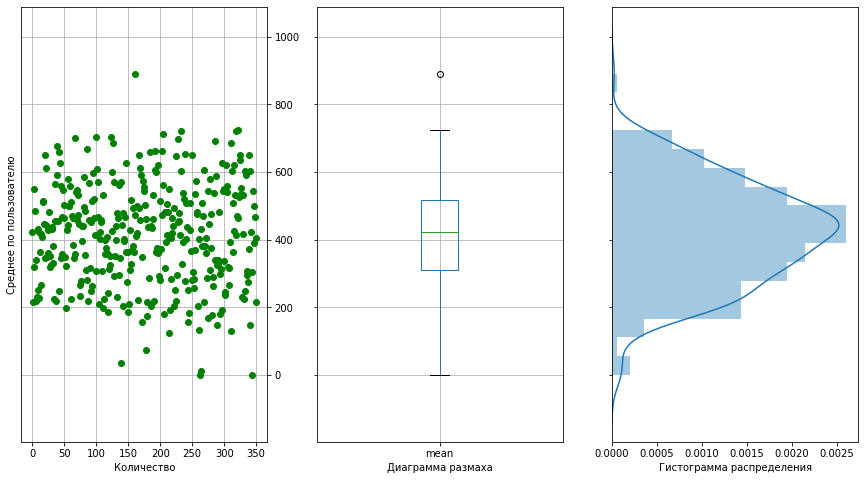

In [33]:
def user_plot(df, column):
    fig, (ax, ax2, ax3) = plt.subplots(ncols=3, sharey=True, figsize=(15,8))
    ax.yaxis.tick_right()

    (df[column].plot(y=column, style='o', c='g', grid= True, legend=False, ax=ax)
                             .set(xlabel='Количество', ylabel='Среднее по пользователю'))
    df.boxplot(column=column, ax=ax2).set(xlabel='Диаграмма размаха')
    sns.distplot(df[column], ax=ax3, vertical=True).set(xlabel='Гистограмма распределения');
user_plot(smart_users_calls, 'mean')
warnings.filterwarnings('ignore')

Для звонков пользователей тарифа Смарт характерна следующая картина: есть несколько выбивающихся значений из представленной выборки,они не сильно влияют на показатели в целом, об этом говорит значение стандартного отклонения. По гистограмме можно сделать предварительный вывод, что распределение **нормальное**

Среднее: 32.0 
Дисперсия: 703.3 
Стандартное отклонение: 26.5


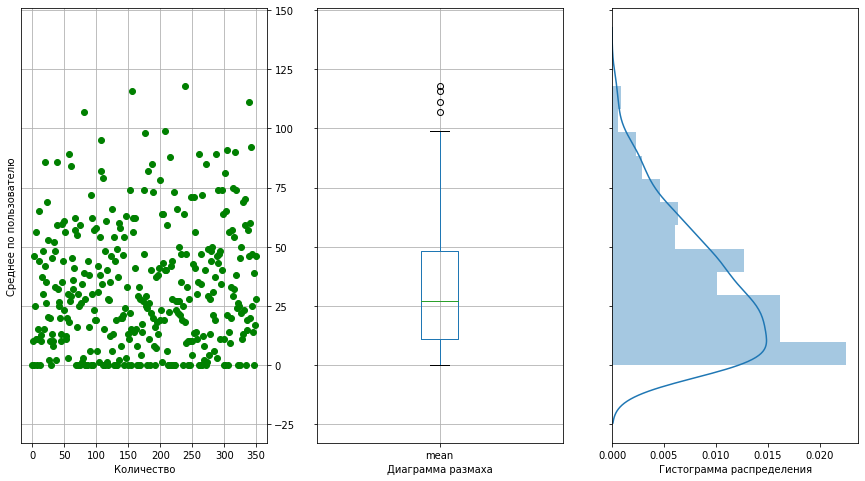

In [34]:
user_stat(smart_users_messages, 'mean')
user_plot(smart_users_messages, 'mean')
warnings.filterwarnings('ignore')

In [35]:
import scipy

In [36]:
stat, p = scipy.stats.shapiro(smart_users_messages['mean']) # тест Шапиро-Уилка
print('Statistics=%.2f, p-value=%.2f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Принять гипотезу о нормальности')
else:
    print('Отклонить гипотезу о нормальности')

Statistics=0.93, p-value=0.00
Отклонить гипотезу о нормальности


Изучение распределения выборки по сообщениям тарифа Смарт говорит о правостороннем смещении значений, а также наличия выбросов(аномалий). Проведенный тест Шапиро-Уилка на нормальность распределения также показал, что распределение назвать нормальным нельзя

Среднее: 16029.5 
Дисперсия: 14379029.9 
Стандартное отклонение: 3792.0


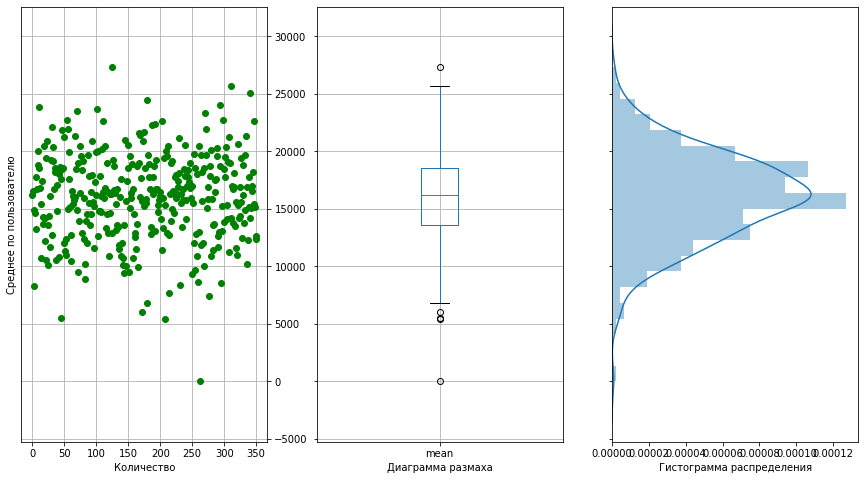

In [37]:
user_stat(smart_users_internet, 'mean')
user_plot(smart_users_internet, 'mean')
warnings.filterwarnings('ignore')

Выбивающиеся значения сверху и снизу диаграммы размаха обозначают крайне высокое и низкое использование интернет-трафика пользователями тарифа Смарт. На гистограмме также заметны два пика плостности распределения, нужно оценить эти значения с точки зрения объема трафика, входящего в стоимость абонентскрй платы (15 гб)

,user_id,tariff_name,month_reg,1,2,3,4,5,6,7,8,9,10,11,12,mean
0,1001,smart,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18452.0,14053.0,16252.500000
1,1002,smart,6,0.0,0.0,0.0,0.0,0.0,10871.0,17601.0,20347.0,16712.0,13905.0,18610.0,18137.0,16597.571429
2,1005,smart,1,2730.0,7394.0,11117.0,9365.0,7877.0,9875.0,7703.0,7554.0,7027.0,7809.0,12682.0,8680.0,8317.750000
3,1006,smart,2,0.0,1395.0,17309.0,13954.0,12984.0,12388.0,20000.0,19327.0,15543.0,19722.0,13275.0,18498.0,14945.000000
4,1007,smart,4,0.0,0.0,0.0,8031.0,17708.0,13674.0,15680.0,20723.0,12630.0,14444.0,16390.0,12512.0,14643.555556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,1494,smart,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6601.0,16986.0,17794.0,18076.0,17645.0,15420.400000
347,1496,smart,1,3766.0,28523.0,24990.0,21098.0,23740.0,20163.0,24395.0,23560.0,26970.0,28215.0,25092.0,20757.0,22605.750000
348,1497,smart,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11512.0,14174.0,19940.0,15208.666667
349,1498,smart,7,0.0,0.0,0.0,0.0,0.0,0.0,7486.0,24270.0,22166.0,20604.0,0.0,0.0,12421.000000


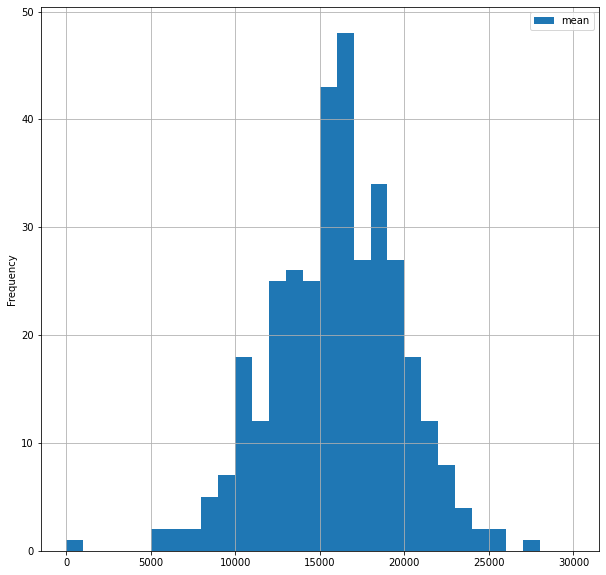

In [38]:
# посмотрим на гистограмму поближе
smart_users_internet.plot(y = 'mean', kind = 'hist', bins = 30, grid=True, figsize = (10,10), range = (0,30000))
smart_users_internet

Видны нкоторые всплески значений, а также выбросы в меньшую и большую сторону гистограммы, при этом распределение близко к нормальному

In [39]:
print("Статистический анализ тарифа Смарт:\n")

print(f"Средняя длительность звонков: {smart_users_calls.mean()}")
print(f"Среднее количество сообщений: {smart_users_messages.mean()}")
print(f"Средний объем интернет-трафика: {smart_users_internet.mean()}")
print(f"Дисперсия: {smart_users_internet.mean()}")
#print(f"Средний объем интернет-трафика: {smart_users_internet.mean()}")
#print(f"Средний объем интернет-трафика: {smart_users_internet.mean()}")


Статистический анализ тарифа Смарт:

Средняя длительность звонков: user_id      1244.133903
month_reg       6.581197
1              19.746439
2              49.356125
3              85.566952
4             117.148148
5             155.606838
6             184.857550
7             233.843305
8             282.179487
9             317.490028
10            356.934473
11            391.863248
12            459.472934
mean          415.784481
dtype: float64
Среднее количество сообщений: user_id      1244.133903
month_reg       6.581197
1               1.766382
2               3.980057
3               6.988604
4               9.809117
5              13.566952
6              15.606838
7              19.327635
8              22.521368
9              24.917379
10             28.282051
11             30.678063
12             34.558405
mean           32.012986
dtype: float64
Средний объем интернет-трафика: user_id       1244.133903
month_reg        6.581197
1              825.729345
2            

Выводы для тарифа **Смарт**
<br />  В среднем, пользователям необходимо 400 минут для разговоров, 32 сообщения и 16000 мб интернет-трафика (примерно 15.6 Гб). Исходя из доступных услуг в тарифе, клиентам компании не хватает интернета на месяц.

#### Анализ тарифа Ультра

Среднее: 518.0 
Дисперсия: 82933.2 
Стандартное отклонение: 288.0


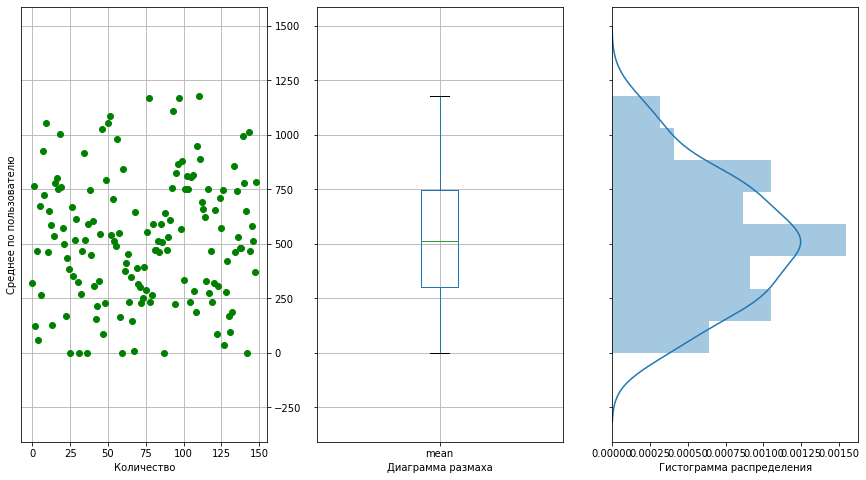

In [40]:
user_stat(ultra_users_calls, 'mean')
user_plot(ultra_users_calls, 'mean')
warnings.filterwarnings('ignore')

Для звонков пользователей тарифа Ультра характерна следующая картина: практически все значения находятся в пределах от 250 до 750 минут, при этом нет крайне низких или высоких значений. Стандратное отклонение, равное 288 говорит о возможном разбросе случайной величины от математического ожидания длительности звонков. По гистограмме можно сделать предварительный вывод, что распределение **нормальное**

In [41]:
stat, p = scipy.stats.shapiro(ultra_users_calls['mean']) # тест Шапиро-Уилка
print('Statistics=%.2f, p-value=%.2f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Принять гипотезу о нормальности')
else:
    print('Отклонить гипотезу о нормальности')

Statistics=0.98, p-value=0.06
Принять гипотезу о нормальности


Среднее: 53.1 
Дисперсия: 2161.2 
Стандартное отклонение: 46.5


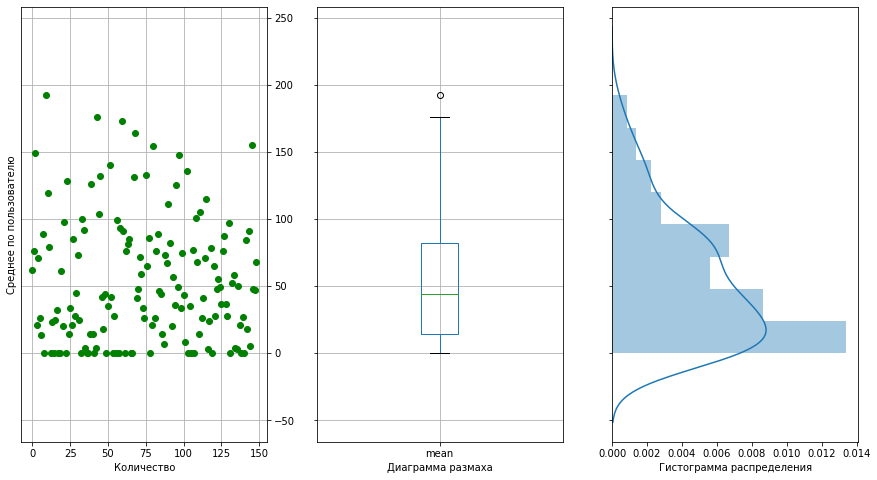

In [42]:
user_stat(ultra_users_messages, 'mean')
user_plot(ultra_users_messages, 'mean')
warnings.filterwarnings('ignore')

Ситуация с сообщениями, входящими в тариф Ультра схожа с тарифом Смарт: большинство пользователей отправляют до 40 сообщений в месяц. Есть крайне высокое значение - 180-190 сообщений, возможно, это используется для коммерческих целей (рассылка)

Среднее: 19152.8 
Дисперсия: 71946841.9 
Стандартное отклонение: 8482.1


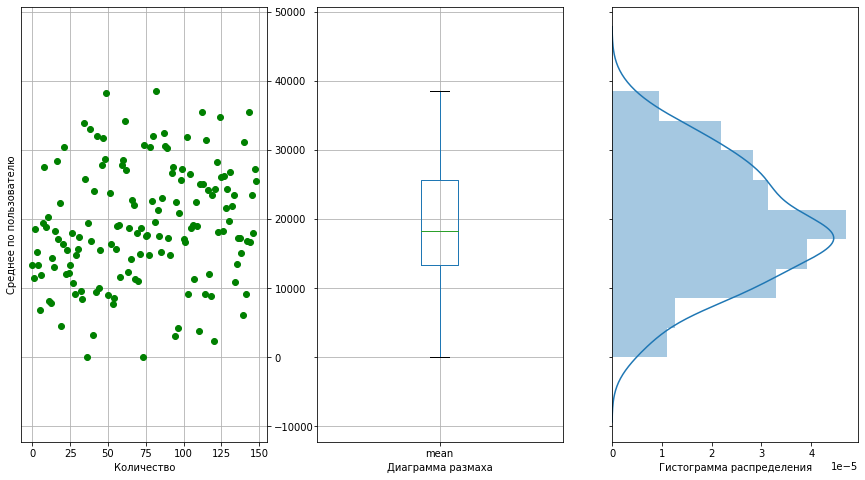

In [43]:
user_stat(ultra_users_internet, 'mean')
user_plot(ultra_users_internet, 'mean')
warnings.filterwarnings('ignore')

Для пользователей тарифа ультра не характерно использование трафика сверх тарифа (30 Гб). Стандартное отклонение равное ~ 8 Гб говорит о разбросе значений относительно среднего на полученную величину. Распределение нормальное

<AxesSubplot:ylabel='Frequency'>

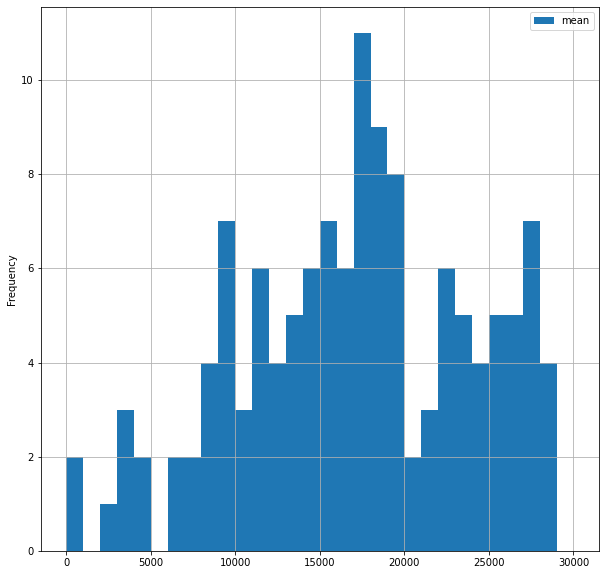

In [44]:
# посмотрим на гистограмму поближе
ultra_users_internet.plot(y = 'mean', kind = 'hist', bins = 30, grid=True, figsize = (10,10), range = (0,30000))


In [45]:
stat, p = scipy.stats.shapiro(ultra_users_internet['mean']) # тест Шапиро-Уилка
print('Statistics=%.2f, p-value=%.2f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Принять гипотезу о нормальности')
else:
    print('Отклонить гипотезу о нормальности')

Statistics=0.99, p-value=0.34
Принять гипотезу о нормальности


По гистограмме получена не совсем очевидная картина: присутствует несколько "гистограмм" внутри одной (несколько вершин), но рапсределение нормальное по тесту Шапиро-Уилка: р-значение сильно больше заданного уровня значимости

In [46]:
print("Статистический анализ тарифа Ультра:\n")

print(f"Средняя длительность звонков: {ultra_users_calls.mean()}")
print(f"Среднее количество сообщений: {ultra_users_messages.mean()}")
print(f"Средний объем интернет-трафика: {ultra_users_internet.mean()}")
print(f"Дисперсия: {ultra_users_internet.mean()}")
#print(f"Средний объем интернет-трафика: {smart_users_internet.mean()}")
#print(f"Средний объем интернет-трафика: {smart_users_internet.mean()}")


Статистический анализ тарифа Ультра:

Средняя длительность звонков: user_id      1262.140940
month_reg       6.248322
1              25.859060
2              47.859060
3             121.590604
4             169.067114
5             229.476510
6             270.436242
7             333.335570
8             366.798658
9             416.348993
10            460.697987
11            486.879195
12            553.020134
mean          518.012821
dtype: float64
Среднее количество сообщений: user_id      1262.140940
month_reg       6.248322
1               2.040268
2               3.536913
3               8.020134
4              11.651007
5              17.020134
6              23.523490
7              30.442953
8              34.785235
9              40.355705
10             48.234899
11             50.174497
12             56.543624
mean           53.147225
dtype: float64
Средний объем интернет-трафика: user_id       1262.140940
month_reg        6.248322
1              794.510067
2           

Выводы для тарифа **Ультра**
<br />  В среднем, пользователям необходимо более 500 минут для разговоров, около 50 сообщений и 19000 мб интернет-трафика (примерно 18.7 Гб). Исходя из доступных услуг в тарифе, обычный пользователь укладывается в заданные границы тарифа

### Проверка гипотез

#### Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается

Для проверки первой гипотезы нужно выдвинуть нулевую и альтернативную гипотезы: Н0 - среднее генеральной совокупности тарифа Смарт равна среднему тарифа Ультра. Альтернативная: Н1 - средние не равны. Проверяется двусторонняя гипотеза с помощью t-теста библиотеки Scipy

In [47]:
smart_total['mean'] = sum(smart_total[str(i) +'_total'] for i in range(1, 13)) / (13 - smart_total['month_reg'])
ultra_total['mean'] = sum(ultra_total[str(i) +'_total'] for i in range(1, 13)) / (13 - ultra_total['month_reg'])
#ultra_total.isna().sum()

In [48]:
from scipy import stats as st

alpha = .01 #  уровень статистической значимости

results = st.ttest_ind(smart_total['mean'], ultra_total['mean'], equal_var = False)

print('средняя выручка тарифа Смарт:', smart_total['mean'].mean())
print('средняя выручка тарифа Ультра:', ultra_total['mean'].mean())
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не отвергаем нулевую гипотезу")

средняя выручка тарифа Смарт: 1260.8891801614022
средняя выручка тарифа Ультра: 2072.1497728967524
p-значение: 1.6367689060041835e-70
Отвергаем нулевую гипотезу


Выручки по двум тарифам сильно разнятся: в среднем, на 700 рублей в месяц. Отклонить гипотезу о равенстве двух генеральных средних позволил т-тест со значением 0.05 статистической значимости. Полученное значение вероятности во много раз меньше этого уровня: с вероятностью 99% можно утверждать, что выручка тарифа Смарт почти в два раза меньше выручк

<div class="alert alert-info"> <b> p-value - уровень значимости, это вероятность отвергнуть нулевую гипотезу, если она верна на самом деле</div>

#### Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

In [49]:
#smart_total.merge(users, how='left', on='user_id')
#ultra_total.merge(users, how='left', on='user_id')
#smart_total.merge(ultra_total, how='outer', on='user_id')

users_city = users.loc[:, ['user_id', 'city', 'tariff_name']]


smart_total_mean = smart_total.loc[:, ['user_id', 'mean']]
ultra_total_mean = ultra_total.loc[:, ['user_id', 'mean']]
total_mean =  (users_city.merge(smart_total_mean, on='user_id', how='left')
                            .merge(ultra_total_mean, on='user_id', how='left')
              ).fillna(0)
total_mean['mean'] = total_mean['mean_x'] + total_mean['mean_y']
total_mean.head()


,user_id,city,tariff_name,mean_x,mean_y,mean
0,1000,Краснодар,ultra,0.000000,1950.0,1950.000000
1,1001,Москва,smart,851.500000,0.0,851.500000
2,1002,Стерлитамак,smart,957.285714,0.0,957.285714
3,1003,Москва,ultra,0.000000,1950.0,1950.000000
4,1004,Новокузнецк,ultra,0.000000,1950.0,1950.000000


Объединила таблицы по пользователям в одну, добавив при этом столбец с названием города из дф users, теперь нужно сделать срез по городу и проверить гипотезу

In [50]:
moscow_users = total_mean.query('city == "Москва"')
other_users = total_mean.query('city != "Москва"')
moscow_users

,user_id,city,tariff_name,mean_x,mean_y,mean
1,1001,Москва,smart,851.500000,0.0,851.500000
3,1003,Москва,ultra,0.000000,1950.0,1950.000000
7,1007,Москва,smart,865.444444,0.0,865.444444
31,1031,Москва,smart,890.500000,0.0,890.500000
33,1033,Москва,smart,1822.333333,0.0,1822.333333
...,...,...,...,...,...,...
453,1453,Москва,ultra,0.000000,1950.0,1950.000000
461,1461,Москва,ultra,0.000000,1950.0,1950.000000
476,1476,Москва,ultra,0.000000,1950.0,1950.000000
481,1481,Москва,smart,1096.727273,0.0,1096.727273


Пользователи из Москвы занимают около 20% всей выборки

Нулевая гипотеза: средняя выручка пользователей из Москвы отличается от выручки пользователей остальных регионов 

In [51]:
alpha = .05 
results = st.ttest_ind(moscow_users['mean'], other_users['mean'], equal_var = False)

print('средняя выручка пользователей из Москвы:', moscow_users['mean'].mean())
print('средняя выручка пользователей других регионов:', other_users['mean'].mean())
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не отвергаем нулевую гипотезу")

средняя выручка пользователей из Москвы: 1458.1572569125601
средняя выручка пользователей других регионов: 1513.6280547728802
p-значение: 0.4213369069965208
Не отвергаем нулевую гипотезу


По результатам статистического теста Стьюдента можно сказать, что средняя выручка пользователей из Москвы не отличается от остальных городов, при этом важно учитывать количество этих пользователей в выборке: всего одна пятая. 

###  Общие выводы

Для решения проекта по изучению перспективного тарифа для телеком-компании было выполнено:
1. Предобработка: замена типов данных там, где это было необходимо, добавлены новые столбцы для более глубого изучения данных
2. Изучение тарифов: посчитаны значения для каждого клиента по совершенным звонкам, сообщениям и использовании интернета
3. Изучена выручка компании по каждому из тарифов
4. Анализ тарифов по статистическим показателям: среднее, дисперсия, среднеквадратическое отклонение
5. Проверены гипотезы о различии выручек по тарифам, а также о равенстве выручки с москвы и других городов

Проект по определению перспективного тарифа для телеком-компании завершен. Оказалось, что для компании почти в два раза выгоднее тариф Ультра, но большая половина пользователей не расходует включенные в тариф минуты/сообщения/интернет-трафик. Я бы предложила оптимизировать пакеты услуг для обоих тарифов.

Проверка гипотез осуществлена с помощью т-теста Стьюдента, так как данные в выборке распределены по нормальному закону. Действительно, средняя выручка по тарифам сильно различается, а вот выручка пользователей из Москвы почти такая же, как от пользователей других городов
